# Tutorial de Redes Neuronales Neuronales Convolucionales usando PyTorch
- Tutorial: [Tutorial profe Cantoral](https://www.youtube.com/watch?v=yUB9JQQVtoU)

Importaciones importantes para la red neuronal y el uso de PyTorch:
Asegurate de instalar todas las librerias con el comando: <code>pip install torch | pip install torchvision</code>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '~/Developer/py/cnn'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINI_BATCH = 64

transform_cifar = T.Compose([
        T.ToTensor(),
        T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

""" Train model with dataset """

# Create training set
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                                    transform=transform_cifar)

# Load training set to the model using DataLoader object
train_loader = DataLoader(cifar10_train, batch_size=MINI_BATCH,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

""" Create validation set and validate model """
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                                    transform=transform_cifar)

val_loader = DataLoader(cifar10_train, batch_size=MINI_BATCH,
                          sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

""" Create test set and test model """
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                                    transform=transform_cifar)

test_loader = DataLoader(cifar10_train, batch_size=MINI_BATCH,
                          sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))


100.0%


Extracting /Users/fervargas/Developer/py/cnn/cifar-10-python.tar.gz to /Users/fervargas/Developer/py/cnn
Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


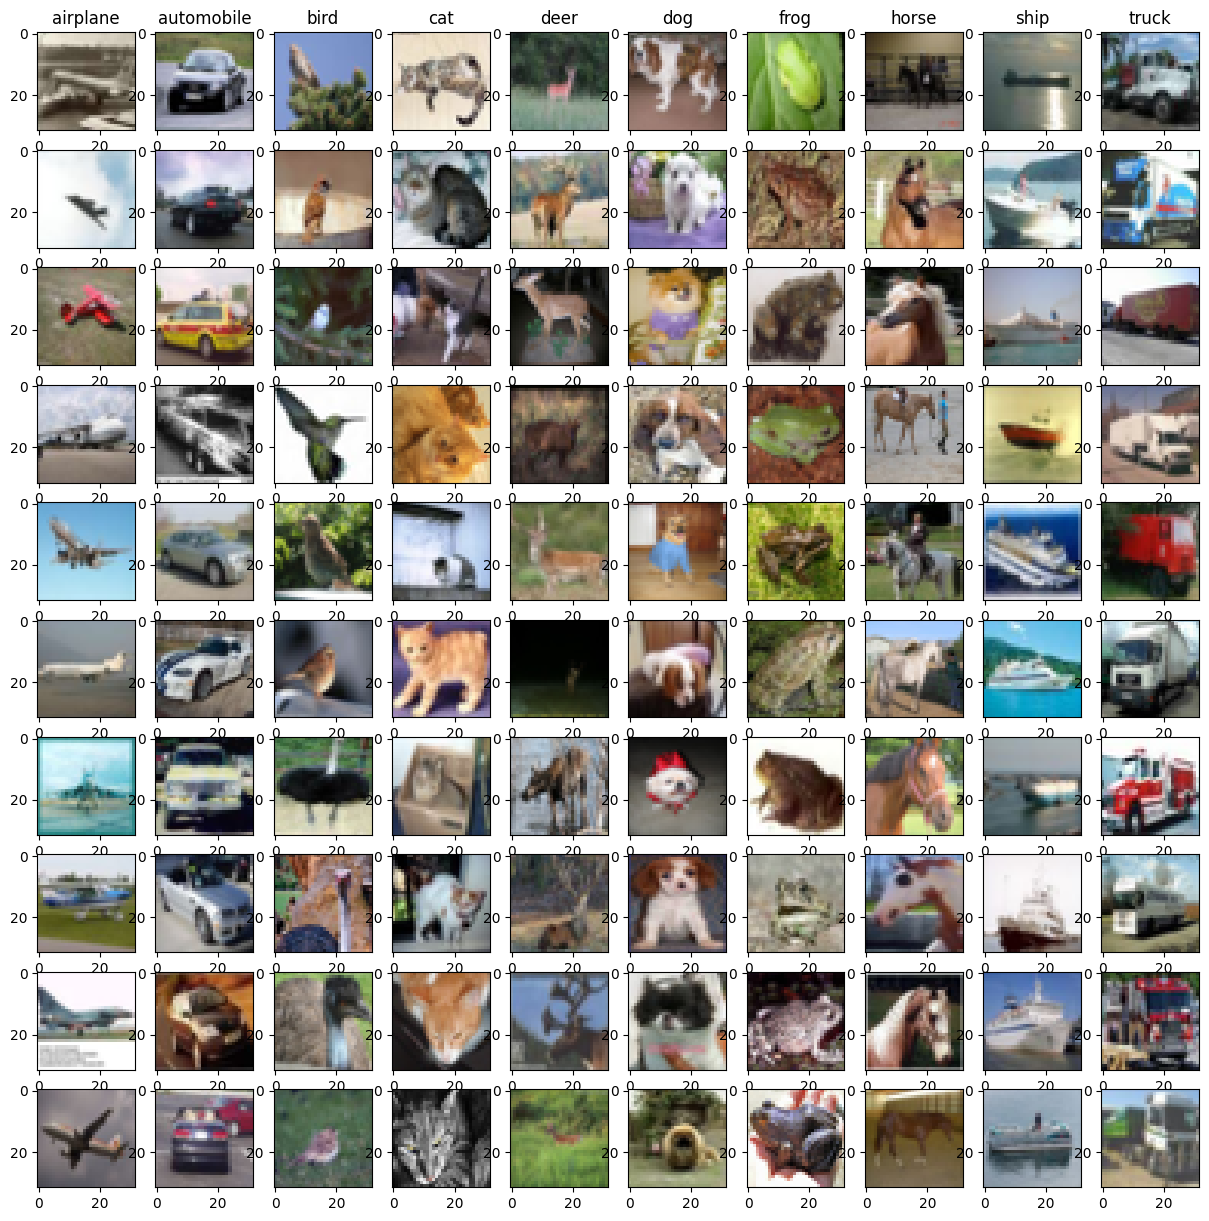

In [4]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 10
    plt.figure(figsize=(15,15))

    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace=False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            # plt.axis('off')

            if i == 0: plt.title(sample)

    plt.show()

plot_cifar10_grid()

# Calculate accuracy

In [5]:
def accuracy(model, loader):
    numCorrect = 0
    numTotal = 0
    model.eval()
    model = model.to(device = device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype= torch.float32)
            yi = yi.to(device=device, dtype= torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            numCorrect += (pred == yi).sum()
            numTotal += pred.size(0)
        return float(numCorrect)/numTotal
            

# Loop de entrenamiento

In [6]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long) 
            scores = model(xi)
            cost = F.cross_entropy(input= scores, target=yi)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        acc = accuracy(model, val_loader)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy:{acc}')


## Secuencia linear

In [7]:
hidden1 = 256
hidden = 256
lr = 0.0001
epochs = 10
model1 = nn.Sequential(
    nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
    nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
    nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)

train(model1, optimiser, epochs)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (6144x32 and 3072x256)

# Sequential CNN

In [ ]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=channel1, 
                                    kernel_size=3, padding=1), 
                            nn.ReLU(),
                            nn.Conv2d(in_channels=channel1, out_channels=channel2,
                                      kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2),
                            nn.Flatten(),
                            nn.Linear(in_features=16*16*channel2, out_features=10)
                        )
optimiser = torch.optim.Adam(modelCNN1.parameters(), lr)

In [ ]:
train(modelCNN1, optimiser, epochs)

# OOP Advanced Tutorial

In [ ]:
con_k3_p1 = lambda channel1, channel2: nn.Conv2d(channel1, channel2, kernel_size=3, padding=1)

class CNNclass(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = con_k3_p1(in_channel, channel1)
        nn.init.kaiming_uniform_(self.conv1.weight)

        self.conv2 = con_k3_p1(channel1, channel2)
        self.max_pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv2(F.felu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)
    
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001
modelCNN3 = CNNclass(3, channel1, channel2)
optimiser = torch.optim.Adam(modelCNN1.parameters(), 1)

In [ ]:
train(modelCNN3, optimiser, epochs)